# Calling Functions

In [2]:
source("Data_Cleaning.R") # normalizing and sampling (class imbalance)
source("Prediction_Power.R") # prediction power

## Remove columns by Variance inflation factor
Analyze the magnitude of multicollinearity by considering the size of the ${\displaystyle \operatorname {VIF} ({\hat {\beta }}_{i})}$. A rule of thumb is that if ${\displaystyle \operatorname {VIF} ({\hat {\beta }}_{i})>10} $ then multicollinearity is high.

In [3]:
remVarsByVIF <- function(x){
  vifs=c()
  vflag=TRUE
  while(vflag){
    VIF <- diag(solve(cor(x)))
    vifs = c(vifs, names(((VIF > 10) & (VIF == max(VIF))))[((VIF > 10) & (VIF == max(VIF)))])
    vflag = any(VIF > 10)
    x = x[,!((VIF > 10) & (VIF == max(VIF)))]
  }
  
  return(x)
}

## creating strata

In [4]:
create_starta <- function(dataset, timestamp , months){
    STRATA_PER_YEAR <- 12 / months
    strata_size <- 60 * 60 * 24 * (365.25/STRATA_PER_YEAR) # Yearly quarters
    #number_of_strata <- floor((max(dataset["commitdate_timestamp"])-min(dataset["commitdate_timestamp"]))/strata_size)
    mymin <- min(dataset[timestamp])
    dataset["strata"] <- (floor((dataset[timestamp] - mymin) / strata_size))
    return(dataset)
}

# RQ1

In [5]:
library(randomForest)
library(MASS)

months_ = 6 #EACH 6 MONTHS
projects = c(#"bugzilla", "columba", 
             "jdt", "platform", "mozilla", "postgres") # target projects


pb <- txtProgressBar(min = 0, max = length(projects), style = 3) # progress bar
for (proj in 1:length(projects)){
    ###############################
    # reading data
    ###############################
    data_name = read.csv(file=file.path("input", paste0(projects[proj],".csv"),sep=""))
    

    ###############################
    # removing index column and sampling if needed.
    ###############################
    sampling = FALSE
    if(sampling){
        fit <- doSampling(data_name,"bug") [,-1]
    } else {
        fit = data_name[,-1]
    }


    ###############################
    # keeping commit date in another variable and then removing that column.
    ###############################
    keep_commitdate = fit["commitdate"]
    fit= fit[-1]


    ###############################
    # normalizing
    ###############################
    idx <- charmatch(c("la","ld","lt","exp","rexp","sexp","ndev","pd","npt","entropy"), colnames(fit))
    fit[,idx] = fit[,idx] + 1
    idx <- charmatch(c("fix","bug"), colnames(fit))
    fit[,-c(idx)] = apply(fit[,-c(idx)], 2, log) 

    ###############################
    # removing highly correlated columns
    ###############################
    idx <- charmatch(c("nm","rexp"), colnames(fit))
    fit = fit[,-c(idx)]

    va <- apply(fit, 2, var)
    fit <- fit[,!(va==0)]

    co <- cor(fit)
    ap <- apply(abs(co) > 0.9999 & upper.tri(co), 2, any)
    fit <- fit[!ap]


    ###############################
    # removing by VIF
    ###############################
    idx <- charmatch(c("bug"), colnames(fit))
    x = fit[,-c(idx)] # remove bug column temporarily
    x <- remVarsByVIF(x)
    fit = cbind(x, fit["bug"])  # add again bug column

    ###############################
    # adding commit date as timestamp
    ###############################
    fit = cbind(keep_commitdate,fit) #adding back commitdate

    # creating timestampe
    commitdate_timestamp = as.numeric(apply(fit["commitdate"], 1, as.POSIXct))
    fit = cbind(commitdate_timestamp, fit)
    fit = fit[order(fit["commitdate_timestamp"]),]
    

    ###############################
    # adding strata column
    ###############################
    fit <- create_starta(fit,"commitdate_timestamp",months_)

    
    ###############################
    # re-sampling on training set
    ###############################
    sampling = TRUE
    if(sampling){
        fit_testing <- fit 
        sampled1 <- lapply(split(fit, fit$strata),doSampling)
        fit_training <- do.call("rbind", sampled1)
    } else {
        fit_testing <- fit
        fit_training <- fit
    }
    
    
    ###############################
    # the total number of strata
    ###############################
    max_ = max(as.numeric(fit$strata))+1
    
    ###############################
    # empty matrix to track the result
    ###############################
    brier_all_mat_6_LR = matrix(NA, nrow = max_ ,ncol = max_)
    brier_last_mat_6_LR = matrix(NA, nrow = max_ ,ncol = max_)
    auc_all_mat_6_LR = matrix(NA, nrow = max_ ,ncol = max_)
    auc_last_mat_6_LR = matrix(NA, nrow = max_ ,ncol = max_)


    ###############################
    # pairwise comparison of the different strata
    ###############################
    for (i in 1:max_){
        if (i == 1){
            next
        }
        strata_cur = i-1
        test = subset(fit_testing, strata == (strata_cur))
        for (j in 0:(strata_cur-1)){
#            print(c("\n","i:",i,"j:",j))
            train_last = subset(fit_training, strata == j)
            train_all = subset(fit_training, strata %in% 0:j)
            
            train_all = train_all[ ,-charmatch(c("strata","commitdate_timestamp","commitdate"),
                                               colnames(train_all))] # remove three columns before glm 
            train_last = train_last[ ,-charmatch(c("strata","commitdate_timestamp","commitdate"), 
                                                 colnames(train_last))] #remove three columns before glm

            ###############################
            # remove non-varient columns
            ###############################
            va <- apply(train_all, 2, var)
            train_all <- train_all[,!(va==0)]
            va <- apply(train_last, 2, var)
            train_last <- train_last[,!(va==0)]
            
            ###############################
            # remove possible duplicate columns
            ###############################
            train_all = train_all[, !duplicated(t(train_all))]
            train_last = train_last[, !duplicated(t(train_last))]

            ###############################
            # remove by VIF
            ###############################
            idx <- charmatch(c("bug"), colnames(train_all))
            x = train_all[,-c(idx)] # remove bug column temporarily
            x <- remVarsByVIF(x)
            train_all = cbind(x, train_all["bug"])  # add again bug column
            
            idx <- charmatch(c("bug"), colnames(train_last))
            x = train_last[,-c(idx)] # remove bug column temporarily
            x <- remVarsByVIF(x)
            train_last = cbind(x, train_last["bug"])  # add again bug column            
            
#            print("\n model all")
#            options(warn=-1)
            #bayesglm
#             model_all = randomForest(as.factor(bug) ~ ., data=train_all, ntree=100, mtry=2, importance=TRUE)
#            model_all = lrm(bug~.,train_all)
            model_all = glm(bug~.,train_all, family=binomial, control = list(maxit = 50))
            options(warn=-1)
            model_all = stepAIC(model_all, k=log(nrow(train_all)), trace = FALSE)
            options(warn=0)
            pred_all = predict(model_all, new=test
                               ,type="response"
#                               ,type="prob"
                               ) #[,"1"]
                                 
            
#            print("\n model last")
#            model_last = lrm(bug~.,train_last)
#           model_last = randomForest(as.factor(bug) ~ ., data=train_last, ntree=100, mtry=2, importance=TRUE)
            model_last = glm(bug~.,train_last, family=binomial, control = list(maxit = 50))
            options(warn=-1)
            model_last = stepAIC(model_last, k=log(nrow(train_last)), trace = FALSE)
            options(warn=0)
            pred_last = predict(model_last, new=test
                               ,type="response"
#                               ,type="prob"
                               ) #[,"1"]
            
            brier_all_mat_6_LR[max_-(j),i] = brier(pred_all,test$bug)
            brier_last_mat_6_LR[max_-(j),i] = brier(pred_last,test$bug)
            auc_all_mat_6_LR[max_-(j),i] = calcROC(pred_all,test$bug)
            auc_last_mat_6_LR[max_-(j),i] = calcROC(pred_last,test$bug)
        }
    }
    
    
    write.csv(brier_all_mat_6_LR, file=file.path("output_Log_Reg", paste0("brier_all_mat_6_",projects[proj],"_LR.csv"), fsep = .Platform$file.sep))
    write.csv(brier_last_mat_6_LR, file=file.path("output_Log_Reg", paste0("brier_last_mat_6_",projects[proj],"_LR.csv"), fsep = .Platform$file.sep))
    write.csv(auc_all_mat_6_LR, file=file.path("output_Log_Reg", paste0("auc_all_mat_6_",projects[proj],"_LR.csv"), fsep = .Platform$file.sep))
    write.csv(auc_last_mat_6_LR, file=file.path("output_Log_Reg", paste0("auc_last_mat_6_",projects[proj],"_LR.csv"), fsep = .Platform$file.sep))

    
    Sys.sleep(0.001)
    setTxtProgressBar(pb, proj)
}

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


  |======================================================================| 100%

# RQ3

In [7]:
options(warn=-1)

print("################################")
print("############# jdt ##############")
auc_all_mat_6_jdt = read.csv("output_Log_Reg\\auc_all_mat_6_jdt_LR.csv",row.names=1)
auc_last_mat_6_jdt = read.csv("output_Log_Reg\\auc_last_mat_6_jdt_LR.csv",row.names=1)

under_diag_auc_all_mat_6_jdt={}
for (i in 2:nrow(auc_all_mat_6_jdt)){
    under_diag_auc_all_mat_6_jdt[i-1]=(auc_all_mat_6_jdt[nrow(auc_all_mat_6_jdt)-i+2,i])
}
round(median(under_diag_auc_all_mat_6_jdt),2)

under_diag_auc_last_mat_6_jdt={}
for (i in 2:nrow(auc_last_mat_6_jdt)){
    under_diag_auc_last_mat_6_jdt[i-1]=(auc_last_mat_6_jdt[nrow(auc_last_mat_6_jdt)-i+2,i])
}
round(median(under_diag_auc_last_mat_6_jdt),2)

len_ = length(under_diag_auc_last_mat_6_jdt)
my_data <- data.frame( 
                Method = rep(c("all", "last"), each = len_),
                AUC = c(under_diag_auc_all_mat_6_jdt,
                        under_diag_auc_last_mat_6_jdt)
                )
wilcox.test(AUC ~ Method, data = my_data, paired = TRUE, alternative = "two.sided")

print("############## jdt #############")
print("################################")
print("################################################################")


print("################################")
print("########### mozilla ############")
auc_all_mat_6_mozilla = read.csv("output_Log_Reg\\auc_all_mat_6_mozilla_LR.csv",row.names=1)
auc_last_mat_6_mozilla = read.csv("output_Log_Reg\\auc_last_mat_6_mozilla_LR.csv",row.names=1)

under_diag_auc_all_mat_6_mozilla={}
for (i in 2:nrow(auc_all_mat_6_mozilla)){
    under_diag_auc_all_mat_6_mozilla[i-1]=(auc_all_mat_6_mozilla[nrow(auc_all_mat_6_mozilla)-i+2,i])
}
round(median(under_diag_auc_all_mat_6_mozilla),2)

under_diag_auc_last_mat_6_mozilla={}
for (i in 2:nrow(auc_last_mat_6_mozilla)){
    under_diag_auc_last_mat_6_mozilla[i-1]=(auc_last_mat_6_mozilla[nrow(auc_last_mat_6_mozilla)-i+2,i])
}
round(median(under_diag_auc_last_mat_6_mozilla),2)

len_ = length(under_diag_auc_last_mat_6_mozilla)
my_data <- data.frame( 
                Method = rep(c("all", "last"), each = len_),
                AUC = c(under_diag_auc_all_mat_6_mozilla,
                        under_diag_auc_last_mat_6_mozilla)
                )
wilcox.test(AUC ~ Method, data = my_data, paired = TRUE, alternative = "two.sided")

print("########### mozilla ############")
print("################################")

print("################################################################")



print("################################")
print("########### platform ###########")
auc_all_mat_6_platform = read.csv("output_Log_Reg\\auc_all_mat_6_platform_LR.csv",row.names=1)
auc_last_mat_6_platform = read.csv("output_Log_Reg\\auc_last_mat_6_platform_LR.csv",row.names=1)

under_diag_auc_all_mat_6_platform={}
for (i in 2:nrow(auc_all_mat_6_platform)){
    under_diag_auc_all_mat_6_platform[i-1]=(auc_all_mat_6_platform[nrow(auc_all_mat_6_platform)-i+2,i])
}
round(median(under_diag_auc_all_mat_6_platform),2)

under_diag_auc_last_mat_6_platform={}
for (i in 2:nrow(auc_last_mat_6_platform)){
    under_diag_auc_last_mat_6_platform[i-1]=(auc_last_mat_6_platform[nrow(auc_last_mat_6_platform)-i+2,i])
}
round(median(under_diag_auc_last_mat_6_platform),2)

len_ = length(under_diag_auc_last_mat_6_platform)
my_data <- data.frame( 
                Method = rep(c("all", "last"), each = len_),
                AUC = c(under_diag_auc_all_mat_6_platform,
                        under_diag_auc_last_mat_6_platform)
                )
wilcox.test(AUC ~ Method, data = my_data, paired = TRUE, alternative = "two.sided")

print("########### platform ###########")
print("################################")

print("################################################################")

print("################################")
print("########### postgres ###########")

auc_all_mat_6_postgres = read.csv("output_Log_Reg\\auc_all_mat_6_postgres_LR.csv",row.names=1)
auc_last_mat_6_postgres = read.csv("output_Log_Reg\\auc_last_mat_6_postgres_LR.csv",row.names=1)

under_diag_auc_all_mat_6_postgres={}
for (i in 2:nrow(auc_all_mat_6_postgres)){
    under_diag_auc_all_mat_6_postgres[i-1]=(auc_all_mat_6_postgres[nrow(auc_all_mat_6_postgres)-i+2,i])
}
round(median(under_diag_auc_all_mat_6_postgres),2)

under_diag_auc_last_mat_6_postgres={}
for (i in 2:nrow(auc_last_mat_6_postgres)){
    under_diag_auc_last_mat_6_postgres[i-1]=(auc_last_mat_6_postgres[nrow(auc_last_mat_6_postgres)-i+2,i])
}
round(median(under_diag_auc_last_mat_6_postgres),2)

len_ = length(under_diag_auc_last_mat_6_postgres)
my_data <- data.frame( 
                Method = rep(c("all", "last"), each = len_),
                AUC = c(under_diag_auc_all_mat_6_postgres,
                        under_diag_auc_last_mat_6_postgres)
                )
wilcox.test(AUC ~ Method, data = my_data, paired = TRUE, alternative = "two.sided")

print("########### postgres ###########")
print("################################")
options(warn=0)

[1] "################################"
[1] "############# jdt ##############"


[1] 0.73

[1] 0.72


	Wilcoxon signed rank test with continuity correction

data:  AUC by Method
V = 63, p-value = 0.06526
alternative hypothesis: true location shift is not equal to 0


[1] "############## jdt #############"
[1] "################################"
[1] "################################################################"
[1] "################################"
[1] "########### mozilla ############"


[1] 0.77

[1] 0.76


	Wilcoxon signed rank test with continuity correction

data:  AUC by Method
V = 72, p-value = 0.01079
alternative hypothesis: true location shift is not equal to 0


[1] "########### mozilla ############"
[1] "################################"
[1] "################################################################"
[1] "################################"
[1] "########### platform ###########"


[1] 0.74

[1] 0.73


	Wilcoxon signed rank test with continuity correction

data:  AUC by Method
V = 45, p-value = 0.6661
alternative hypothesis: true location shift is not equal to 0


[1] "########### platform ###########"
[1] "################################"
[1] "################################################################"
[1] "################################"
[1] "########### postgres ###########"


[1] 0.78

[1] 0.77


	Wilcoxon signed rank test with continuity correction

data:  AUC by Method
V = 334, p-value = 5.998e-05
alternative hypothesis: true location shift is not equal to 0


[1] "########### postgres ###########"
[1] "################################"


In [8]:
options(warn=-1)

print("################################")
print("############# jdt ##############")
brier_all_mat_6_jdt = read.csv("output_Log_Reg\\brier_all_mat_6_jdt_LR.csv",row.names=1)
brier_last_mat_6_jdt = read.csv("output_Log_Reg\\brier_last_mat_6_jdt_LR.csv",row.names=1)

under_diag_brier_all_mat_6_jdt={}
for (i in 2:nrow(brier_all_mat_6_jdt)){
    under_diag_brier_all_mat_6_jdt[i-1]=(brier_all_mat_6_jdt[nrow(brier_all_mat_6_jdt)-i+2,i])
}
round(median(under_diag_brier_all_mat_6_jdt),2)

under_diag_brier_last_mat_6_jdt={}
for (i in 2:nrow(brier_last_mat_6_jdt)){
    under_diag_brier_last_mat_6_jdt[i-1]=(brier_last_mat_6_jdt[nrow(brier_last_mat_6_jdt)-i+2,i])
}
round(median(under_diag_brier_last_mat_6_jdt),2)

len_ = length(under_diag_brier_last_mat_6_jdt)
my_data <- data.frame( 
                Method = rep(c("all", "last"), each = len_),
                brier = c(under_diag_brier_all_mat_6_jdt,
                        under_diag_brier_last_mat_6_jdt)
                )
wilcox.test(brier ~ Method, data = my_data, paired = TRUE, alternative = "less")

print("############## jdt #############")
print("################################")
print("################################################################")

print("################################")
print("########### mozilla ############")
brier_all_mat_6_mozilla = read.csv("output_Log_Reg\\brier_all_mat_6_mozilla_LR.csv",row.names=1)
brier_last_mat_6_mozilla = read.csv("output_Log_Reg\\brier_last_mat_6_mozilla_LR.csv",row.names=1)

under_diag_brier_all_mat_6_mozilla={}
for (i in 2:nrow(brier_all_mat_6_mozilla)){
    under_diag_brier_all_mat_6_mozilla[i-1]=(brier_all_mat_6_mozilla[nrow(brier_all_mat_6_mozilla)-i+2,i])
}
round(median(under_diag_brier_all_mat_6_mozilla),2)

under_diag_brier_last_mat_6_mozilla={}
for (i in 2:nrow(brier_last_mat_6_mozilla)){
    under_diag_brier_last_mat_6_mozilla[i-1]=(brier_last_mat_6_mozilla[nrow(brier_last_mat_6_mozilla)-i+2,i])
}
round(median(under_diag_brier_last_mat_6_mozilla),2)

len_ = length(under_diag_brier_last_mat_6_mozilla)
my_data <- data.frame( 
                Method = rep(c("all", "last"), each = len_),
                brier = c(under_diag_brier_all_mat_6_mozilla,
                        under_diag_brier_last_mat_6_mozilla)
                )
wilcox.test(brier ~ Method, data = my_data, paired = TRUE, alternative = "less")

print("########### mozilla ############")
print("################################")

print("################################################################")



print("################################")
print("########### platform ###########")
brier_all_mat_6_platform = read.csv("output_Log_Reg\\brier_all_mat_6_platform_LR.csv",row.names=1)
brier_last_mat_6_platform = read.csv("output_Log_Reg\\brier_last_mat_6_platform_LR.csv",row.names=1)

under_diag_brier_all_mat_6_platform={}
for (i in 2:nrow(brier_all_mat_6_platform)){
    under_diag_brier_all_mat_6_platform[i-1]=(brier_all_mat_6_platform[nrow(brier_all_mat_6_platform)-i+2,i])
}
round(median(under_diag_brier_all_mat_6_platform),2)

under_diag_brier_last_mat_6_platform={}
for (i in 2:nrow(brier_last_mat_6_platform)){
    under_diag_brier_last_mat_6_platform[i-1]=(brier_last_mat_6_platform[nrow(brier_last_mat_6_platform)-i+2,i])
}
round(median(under_diag_brier_last_mat_6_platform),2)

len_ = length(under_diag_brier_last_mat_6_platform)
my_data <- data.frame( 
                Method = rep(c("all", "last"), each = len_),
                brier = c(under_diag_brier_all_mat_6_platform,
                        under_diag_brier_last_mat_6_platform)
                )
wilcox.test(brier ~ Method, data = my_data, paired = TRUE, alternative = "less")

print("########### platform ###########")
print("################################")

print("################################################################")

print("################################")
print("########### postgres ###########")

brier_all_mat_6_postgres = read.csv("output_Log_Reg\\brier_all_mat_6_postgres_LR.csv",row.names=1)
brier_last_mat_6_postgres = read.csv("output_Log_Reg\\brier_last_mat_6_postgres_LR.csv",row.names=1)

under_diag_brier_all_mat_6_postgres={}
for (i in 2:nrow(brier_all_mat_6_postgres)){
    under_diag_brier_all_mat_6_postgres[i-1]=(brier_all_mat_6_postgres[nrow(brier_all_mat_6_postgres)-i+2,i])
}
round(median(under_diag_brier_all_mat_6_postgres),2)

under_diag_brier_last_mat_6_postgres={}
for (i in 2:nrow(brier_last_mat_6_postgres)){
    under_diag_brier_last_mat_6_postgres[i-1]=(brier_last_mat_6_postgres[nrow(brier_last_mat_6_postgres)-i+2,i])
}
round(median(under_diag_brier_last_mat_6_postgres),2)

len_ = length(under_diag_brier_last_mat_6_postgres)
my_data <- data.frame( 
                Method = rep(c("all", "last"), each = len_),
                brier = c(under_diag_brier_all_mat_6_postgres,
                        under_diag_brier_last_mat_6_postgres)
                )
wilcox.test(brier ~ Method, data = my_data, paired = TRUE, alternative = "less")

print("########### postgres ###########")
print("################################")
options(warn=0)

[1] "################################"
[1] "############# jdt ##############"


[1] 0.2

[1] 0.21


	Wilcoxon signed rank test with continuity correction

data:  brier by Method
V = 0, p-value = 0.001263
alternative hypothesis: true location shift is less than 0


[1] "############## jdt #############"
[1] "################################"
[1] "################################################################"
[1] "################################"
[1] "########### mozilla ############"


[1] 0.18

[1] 0.19


	Wilcoxon signed rank test with continuity correction

data:  brier by Method
V = 29, p-value = 0.2281
alternative hypothesis: true location shift is less than 0


[1] "########### mozilla ############"
[1] "################################"
[1] "################################################################"
[1] "################################"
[1] "########### platform ###########"


[1] 0.21

[1] 0.21


	Wilcoxon signed rank test with continuity correction

data:  brier by Method
V = 55, p-value = 0.9022
alternative hypothesis: true location shift is less than 0


[1] "########### platform ###########"
[1] "################################"
[1] "################################################################"
[1] "################################"
[1] "########### postgres ###########"


[1] 0.18

[1] 0.19


	Wilcoxon signed rank test with continuity correction

data:  brier by Method
V = 9, p-value = 1.243e-05
alternative hypothesis: true location shift is less than 0


[1] "########### postgres ###########"
[1] "################################"


# RQ4

In [10]:
METRICS_FAMILIES <- list(
                         Size=c("la", "ld", "lt"),
                         Diffusion=c("ns", "nm", "nf", "entropy"),
                         Purpose = "fix",
                         History=c("ndev","pd","npt"),
                         Author=c("exp", #"rexp", 
                                  "sexp")
                        )
row_ = length(names(METRICS_FAMILIES))

library(MASS)

months_ = 6 #EACH 6 MONTHS
projects = c(#"bugzilla", "columba", 
             "jdt", "platform", "mozilla", "postgres") # target projects
row_ = length(names(METRICS_FAMILIES))

pb <- txtProgressBar(min = 0, max = length(projects), style = 3) # progress bar
for (proj in 1:length(projects)){


    ###############################
    # reading data
    ###############################
    data_name = read.csv(file=file.path("input", paste0(projects[proj],".csv"),sep=""))
    

    ###############################
    # removing index column and sampling if needed.
    ###############################
    sampling = FALSE
    if(sampling){
        fit <- doSampling(data_name,"bug") [,-1]
    } else {
        fit = data_name[,-1]
    }


    ###############################
    # keeping commit date in another variable and then removing that column.
    ###############################
    keep_commitdate = fit["commitdate"]
    fit= fit[-1]


    ###############################
    # normalizing
    ###############################
    idx <- charmatch(c("la","ld","lt","exp","rexp","sexp","ndev","pd","npt","entropy"), colnames(fit))
    fit[,idx] = fit[,idx] + 1
    idx <- charmatch(c("fix","bug"), colnames(fit))
    fit[,-c(idx)] = apply(fit[,-c(idx)], 2, log) 

    ###############################
    # removing highly correlated columns
    ###############################
    idx <- charmatch(c("nm","rexp"), colnames(fit))
    fit = fit[,-c(idx)]

    va <- apply(fit, 2, var)
    fit <- fit[,!(va==0)]

    co <- cor(fit)
    ap <- apply(abs(co) > 0.9999 & upper.tri(co), 2, any)
    fit <- fit[!ap]


    ###############################
    # removing by VIF
    ###############################
    idx <- charmatch(c("bug"), colnames(fit))
    x = fit[,-c(idx)] # remove bug column temporarily
    x <- remVarsByVIF(x)
    fit = cbind(x, fit["bug"])  # add again bug column

    ###############################
    # adding commit date as timestamp
    ###############################
    fit = cbind(keep_commitdate,fit) #adding back commitdate

    # creating timestampe
    commitdate_timestamp = as.numeric(apply(fit["commitdate"], 1, as.POSIXct))
    fit = cbind(commitdate_timestamp, fit)
    fit = fit[order(fit["commitdate_timestamp"]),]
    

    ###############################
    # adding strata column
    ###############################
    fit <- create_starta(fit,"commitdate_timestamp",months_)

    
    ###############################
    # re-sampling on training set
    ###############################
    sampling = TRUE
    if(sampling){
        fit_testing <- fit 
        sampled1 <- lapply(split(fit, fit$strata),doSampling)
        fit_training = do.call("rbind", sampled1)
    }
    
    
    ###############################
    # the total number of strata
    ###############################
    max_ = max(as.numeric(fit$strata)) + 1
    
    ###############################
    # empty matrix to track the result
    ###############################
    brier_all_mat_6_Q4_LR = matrix(NA, nrow = max_ ,ncol = max_)
    auc_all_mat_6_Q4_LR = matrix(NA, nrow = max_ ,ncol = max_)


    ###############################
    # pairwise comparison of the different strata
    ###############################
    for (i in 1:max_){
        if (i == 1){
            next
        }
        
        
    ###############################
    # new
    ###############################
    strata_cur = i - 1
    test = subset(fit_testing, as.numeric(strata) == strata_cur)
    for (j in 0:(strata_cur-1)){
        first_it = T
        for (jj in 1:j){
            train_all_temp = subset(fit_testing, as.numeric(strata) == jj)
            if (j==0){
                ratio_ = 1 
            } else {
                ratio_ = 1 - ((j-jj)/j)
            }

            sampled_index = sample(floor(ratio_ * nrow(train_all_temp)))
            if (first_it){
                train_all = train_all_temp[sampled_index,]
                first_it = FALSE
            } else {
                train_all = rbind(train_all, train_all_temp[sampled_index,])
            }  
        }
    ###############################
    # new
    ###############################          
        
#         strata_cur = i-1
#         test = subset(fit_testing, strata == (strata_cur))
#         for (j in 0:(strata_cur-1)){
# #            print(c("\n","i:",i,"j:",j))
#             train_last = subset(fit_training, strata == j)
#             train_all = subset(fit_training, strata %in% 0:j)
            
            train_all = train_all[ ,-charmatch(c("strata","commitdate_timestamp","commitdate"),
                                               colnames(train_all))] # remove three columns before glm 
#             train_last = train_last[ ,-charmatch(c("strata","commitdate_timestamp","commitdate"), 
#                                                  colnames(train_last))] #remove three columns before glm

            ###############################
            # remove non-varient columns
            ###############################
            va <- apply(train_all, 2, var)
            train_all <- train_all[,!(va==0)]
            
            ###############################
            # remove possible duplicate columns
            ###############################
            train_all = train_all[, !duplicated(t(train_all))]

            ###############################
            # remove by VIF
            ###############################
            idx <- charmatch(c("bug"), colnames(train_all))
            x = train_all[,-c(idx)] # remove bug column temporarily
            x <- remVarsByVIF(x)
            train_all = cbind(x, train_all["bug"])  # add again bug column       
            
#            print("\n model all")
#            options(warn=-1)
            #bayesglm
#            model_all = lrm(bug~.,train_all)
#            model_all = randomForest(as.factor(bug) ~ ., data=train_all, ntree=100, mtry=2, importance=TRUE)


            model_all = glm(bug~.,train_all, family=binomial, control = list(maxit = 50))
            options(warn=-1)
            model_all = stepAIC(model_all, k=log(nrow(train_all)), trace = FALSE)
            options(warn=0)
            pred_all = predict(model_all, new=test
#                               , type = "prob"
                               ,type="response"
                              ) #[,"1"]
            
            
            
            brier_all_mat_6_Q4_LR[max_-(j),i] = brier(pred_all,test$bug)
            auc_all_mat_6_Q4_LR[max_-(j),i] = calcROC(pred_all,test$bug)
        }
    }
    
    
    write.csv(brier_all_mat_6_Q4_LR, file=file.path("output_Log_Reg", paste0("brier_all_mat_6_Q4_",projects[proj],"_LR.csv"), fsep = .Platform$file.sep),row.names=FALSE)
    write.csv(auc_all_mat_6_Q4_LR, file=file.path("output_Log_Reg", paste0("auc_all_mat_6_Q4_",projects[proj],"_LR.csv"), fsep = .Platform$file.sep),row.names=FALSE)

    
    Sys.sleep(0.001)
    setTxtProgressBar(pb, proj)
}

  |======================================================================| 100%

Warning message:
"package 'reshape2' was built under R version 3.5.3"

$statistic
Kruskal-Wallis chi-squared 
                 0.5474847 

$parameter
df 
 2 

$p.value
[1] 0.760528

$method
[1] "Kruskal-Wallis rank sum test"

$data.name
[1] "AUC by Var2"

[[6]]
[1] "jdt"



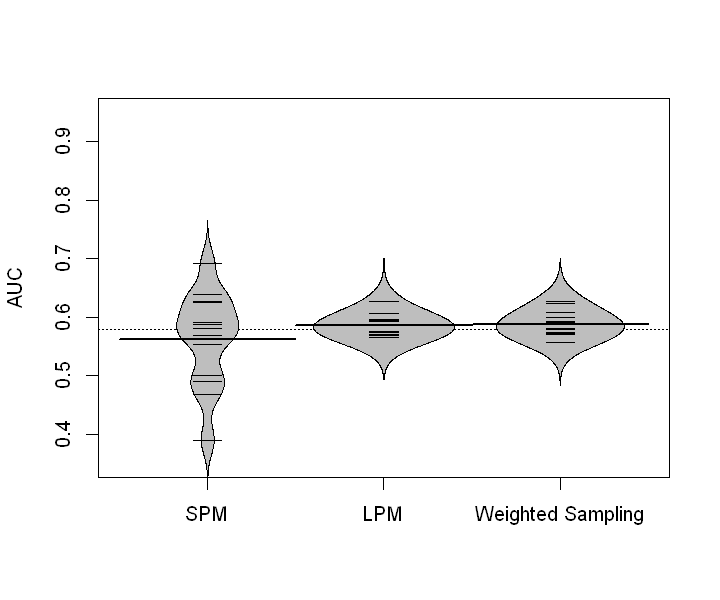

$statistic
Kruskal-Wallis chi-squared 
                  1.841311 

$parameter
df 
 2 

$p.value
[1] 0.398258

$method
[1] "Kruskal-Wallis rank sum test"

$data.name
[1] "AUC by Var2"

[[6]]
[1] "mozilla"



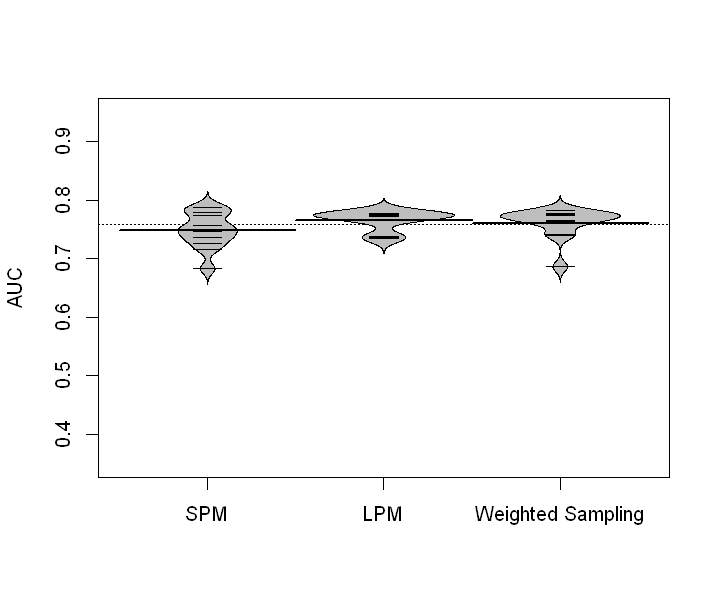

$statistic
Kruskal-Wallis chi-squared 
                   2.18099 

$parameter
df 
 2 

$p.value
[1] 0.3360501

$method
[1] "Kruskal-Wallis rank sum test"

$data.name
[1] "AUC by Var2"

[[6]]
[1] "platform"



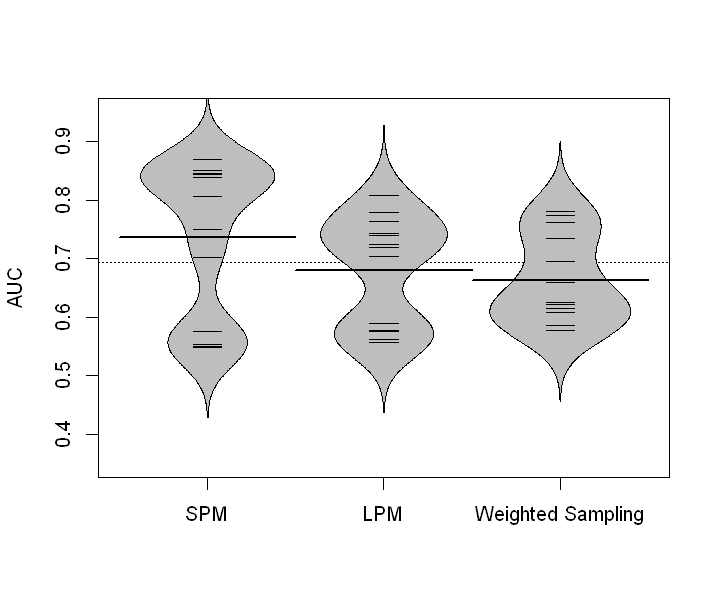

$statistic
Kruskal-Wallis chi-squared 
                  2.332944 

$parameter
df 
 2 

$p.value
[1] 0.3114639

$method
[1] "Kruskal-Wallis rank sum test"

$data.name
[1] "AUC by Var2"

[[6]]
[1] "postgres"



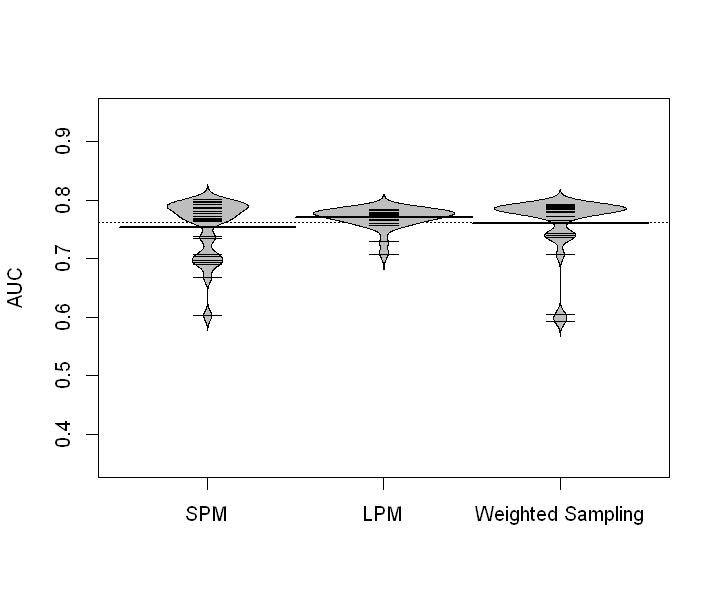

In [11]:
projects = c(#"bugzilla", "columba",
    "jdt", "mozilla", "platform", "postgres") # target projects
options(repr.plot.width=6, repr.plot.height=5)

for (proj in projects){
    all_dat = read.csv(paste0('output_Log_Reg/auc_all_mat_6_',proj,'_LR.csv'))[,-1]
    last_dat =  read.csv(paste0('output_Log_Reg/auc_last_mat_6_',proj,'_LR.csv'))[,-1]
    weighted_dat =  read.csv(paste0('output_Log_Reg/auc_all_mat_6_Q4_',proj,'_LR.csv'))

    library(reshape2)
    library(beanplot)
    length_ = ncol(weighted_dat)
    AUC_values = cbind(last_dat[,length_][-1],
                            all_dat[,length_][-1],
                            weighted_dat[,length_][-1])
    #openstack_3_AUC = cbind(openstack_3_AUC, rep(c("SPM","LPM","Weighted Sampling"),each = (length_-1)))
    #colnames(openstack_3_AUC) = c("AUC","Method")
    colnames(AUC_values) = c("SPM","LPM","Weighted Sampling")

    AUC_values_Long = melt(AUC_values, id.vars = list(colnames(AUC_values)))
    colnames(AUC_values_Long) <- c("Var1","Var2","AUC")

    beanplot(AUC~Var2,data=AUC_values_Long,log="",col="gray",method="jitter",ylim=c(0.35,0.95),
             ylab = "AUC"
             #, main = proj
            )
    print(c(kruskal.test(AUC~Var2,data=AUC_values_Long), proj))
} 

$statistic
Kruskal-Wallis chi-squared 
                  26.03429 

$parameter
df 
 2 

$p.value
[1] 2.221904e-06

$method
[1] "Kruskal-Wallis rank sum test"

$data.name
[1] "AUC by Var2"

[[6]]
[1] "jdt"



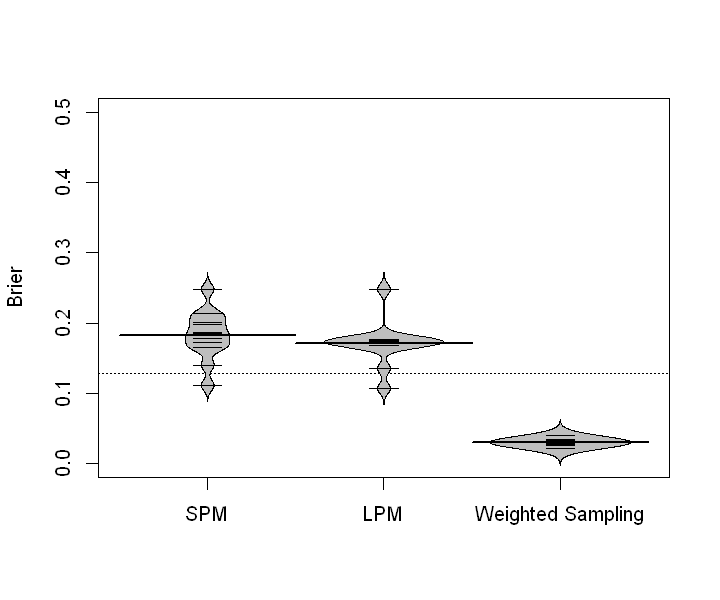

$statistic
Kruskal-Wallis chi-squared 
                  25.58454 

$parameter
df 
 2 

$p.value
[1] 2.782193e-06

$method
[1] "Kruskal-Wallis rank sum test"

$data.name
[1] "AUC by Var2"

[[6]]
[1] "mozilla"



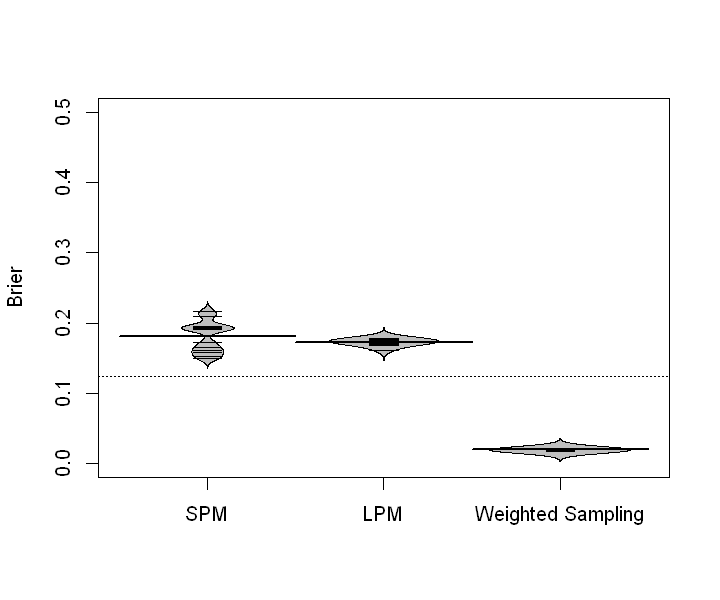

$statistic
Kruskal-Wallis chi-squared 
                  16.96888 

$parameter
df 
 2 

$p.value
[1] 0.0002066594

$method
[1] "Kruskal-Wallis rank sum test"

$data.name
[1] "AUC by Var2"

[[6]]
[1] "platform"



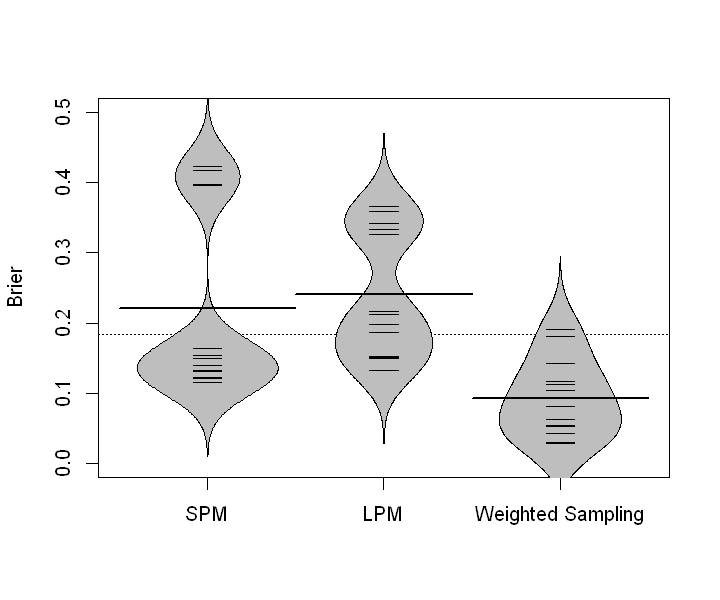

$statistic
Kruskal-Wallis chi-squared 
                  52.98226 

$parameter
df 
 2 

$p.value
[1] 3.126422e-12

$method
[1] "Kruskal-Wallis rank sum test"

$data.name
[1] "AUC by Var2"

[[6]]
[1] "postgres"



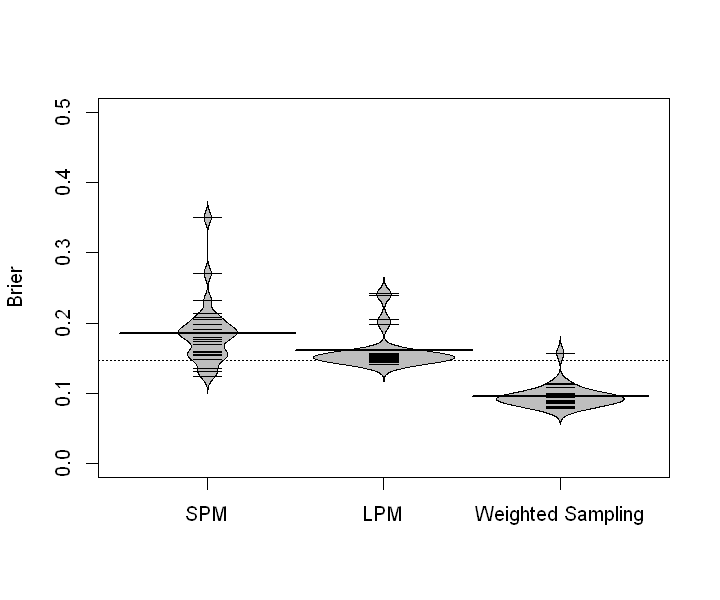

In [13]:
projects = c(#"bugzilla", "columba", 
             "jdt", "mozilla", "platform", "postgres") # target projects
options(repr.plot.width=6, repr.plot.height=5)

for (proj in projects){
    all_dat = read.csv(paste0('output_Log_Reg/brier_all_mat_6_',proj,'_LR.csv'))[,-1]
    last_dat =  read.csv(paste0('output_Log_Reg/brier_last_mat_6_',proj,'_LR.csv'))[,-1]
    weighted_dat =  read.csv(paste0('output_Log_Reg/brier_all_mat_6_Q4_',proj,'_LR.csv'))

    library(reshape2)
    library(beanplot)
    length_ = ncol(weighted_dat)
    AUC_values = cbind(last_dat[,length_][-1],
                            all_dat[,length_][-1],
                            weighted_dat[,length_][-1])
    #openstack_3_AUC = cbind(openstack_3_AUC, rep(c("SPM","LPM","Weighted Sampling"),each = (length_-1)))
    #colnames(openstack_3_AUC) = c("AUC","Method")
    colnames(AUC_values) = c("SPM","LPM","Weighted Sampling")

    AUC_values_Long = melt(AUC_values, id.vars = list(colnames(AUC_values)))
    colnames(AUC_values_Long) <- c("Var1","Var2","AUC")

    beanplot(AUC~Var2,data=AUC_values_Long,log="",col="gray",method="jitter",ylim=c(0.0,0.5),
             ylab = "Brier"
             #, main = proj
            )
    print(c(kruskal.test(AUC~Var2,data=AUC_values_Long), proj))
} 